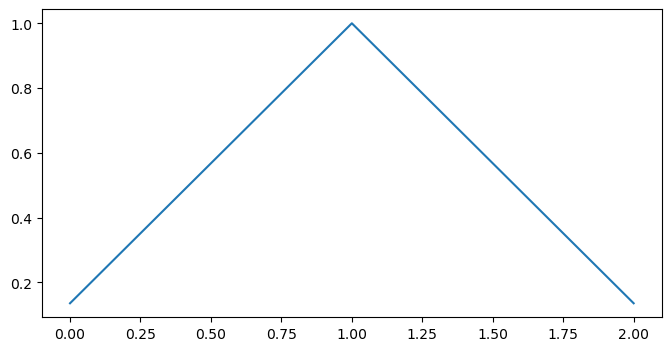

In [4]:
import numpy as np
from scipy.signal import windows
import matplotlib.pyplot as plt

width1 = 3
amp1 = 1

sigma1 = width1 / 6
gauss_1 = amp1 * windows.gaussian(width1, std=sigma1)

plt.figure(figsize=(8, 4))
plt.plot(gauss_1)
plt.show()

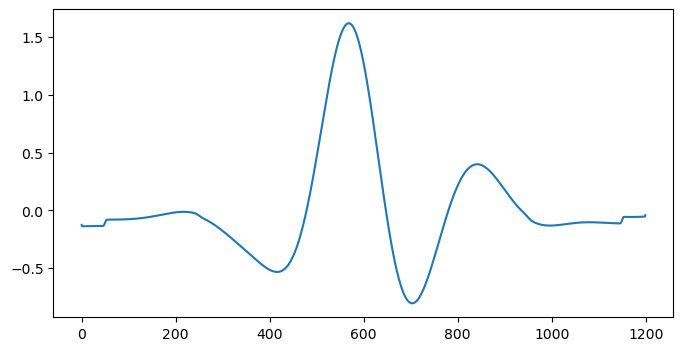

In [22]:
import numpy as np
from scipy.signal import windows
import matplotlib.pyplot as plt
from sharp_ss.model import Model, Prior
from sharp_ss.forward import create_G_from_model, convolve_P_G

tmp = np.loadtxt('ocean_stack.csv', delimiter=",", skiprows=1)
Ptime = tmp[:,0]
P = tmp[:,1]

dt = Ptime[1] - Ptime[0]

prior = Prior(tlen=Ptime[-1], stdP=0.1, dt=dt, widRange=(0.1, 5))
model = Model(Nphase=2, loc=np.array([5,25]), amp=np.array([-0.15,0.02]), wid=np.array([1,3]), sig=0, nc1=0, nc2=0)

G = create_G_from_model(model=model, prior=prior)
D = convolve_P_G(P, G)

plt.figure(figsize=(8, 4))
plt.plot(D)
plt.show()

# Save
np.savez("./synthetic_1/synthetic_1.npz", P=P, D=D, G=G)

import pickle

# Save prior
with open("./synthetic_1/prior.pkl", "wb") as f:
    pickle.dump(prior, f)

# Save model
with open("./synthetic_1/model.pkl", "wb") as f:
    pickle.dump(model, f)



In [4]:
import os
import numpy as np
import pickle

# Load synthetic model output
data = np.load("./synthetic_1/synthetic_1.npz")
P = data["P"]
D_clean = data["D"]
G = data["G"]

with open("./synthetic_1/prior.pkl", "rb") as f:
    prior = pickle.load(f)

with open("./synthetic_1/model.pkl", "rb") as f:
    model = pickle.load(f)

# Output directory
output_dir = "./synthetic_1/Noise/"
os.makedirs(output_dir, exist_ok=True)

# Noise parameters from Kolb and Lekic (2014)
lambda_ = 0.2
omega0 = 4.4

# Time vector
time = np.arange(len(P)) * prior.dt
lenT = len(time)
noise_ct = 50

# Construct covariance matrix
CovMat = np.zeros((lenT, lenT))
for i in range(lenT):
    for j in range(lenT):
        tdiff = abs(time[j] - time[i])
        CovMat[i, j] = np.exp(-lambda_ * tdiff) * np.cos(lambda_ * omega0 * tdiff)

# Cholesky decomposition for correlated noise
L = np.linalg.cholesky(CovMat)

# Matrix to hold all noisy traces
all_noisy_traces = np.zeros((lenT, noise_ct))

# Generate noise and store in matrix
for inoise in range(noise_ct):
    raw_noise = L @ np.random.randn(lenT)
    raw_noise = 2 * (raw_noise - raw_noise.min()) / (raw_noise.max() - raw_noise.min()) - 1  # Normalize to [-1, 1]
    this_noise = 0.1 * raw_noise
    D_noisy = D_clean + this_noise
    all_noisy_traces[:, inoise] = D_noisy

# Save to CSV
csv_path = os.path.join(output_dir, "noisy_traces.csv")
np.savetxt(csv_path, all_noisy_traces, delimiter=",")

print(f"Saved noisy traces to {csv_path}, shape: {all_noisy_traces.shape}")


Saved noisy traces to ./synthetic_1/Noise/noisy_traces.csv, shape: (1200, 50)


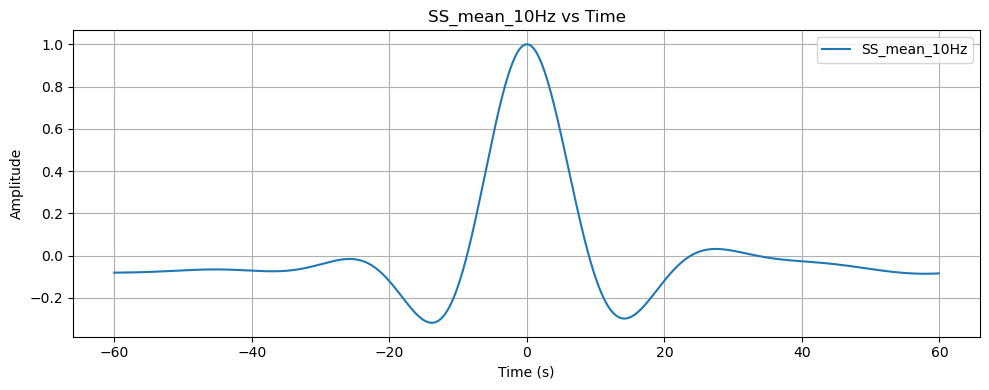

In [1]:
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the .mat file
mat = scipy.io.loadmat('/Users/evanzhang/evan.z.0920@gmail.com - Google Drive/My Drive/Research/SS_THBD/DataMats/OceanStack.mat')

# Extract and flatten the vectors
time_OS = mat['time_OS'].flatten()
SS_mean_10Hz = mat['SS_mean_10Hz'].flatten()

# Save to CSV
df = pd.DataFrame({
    'time': time_OS,
    'P': SS_mean_10Hz
})
df.to_csv('output.csv', index=False)

# Plot the data
plt.figure(figsize=(10, 4))
plt.plot(time_OS, SS_mean_10Hz, label='SS_mean_10Hz')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('SS_mean_10Hz vs Time')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


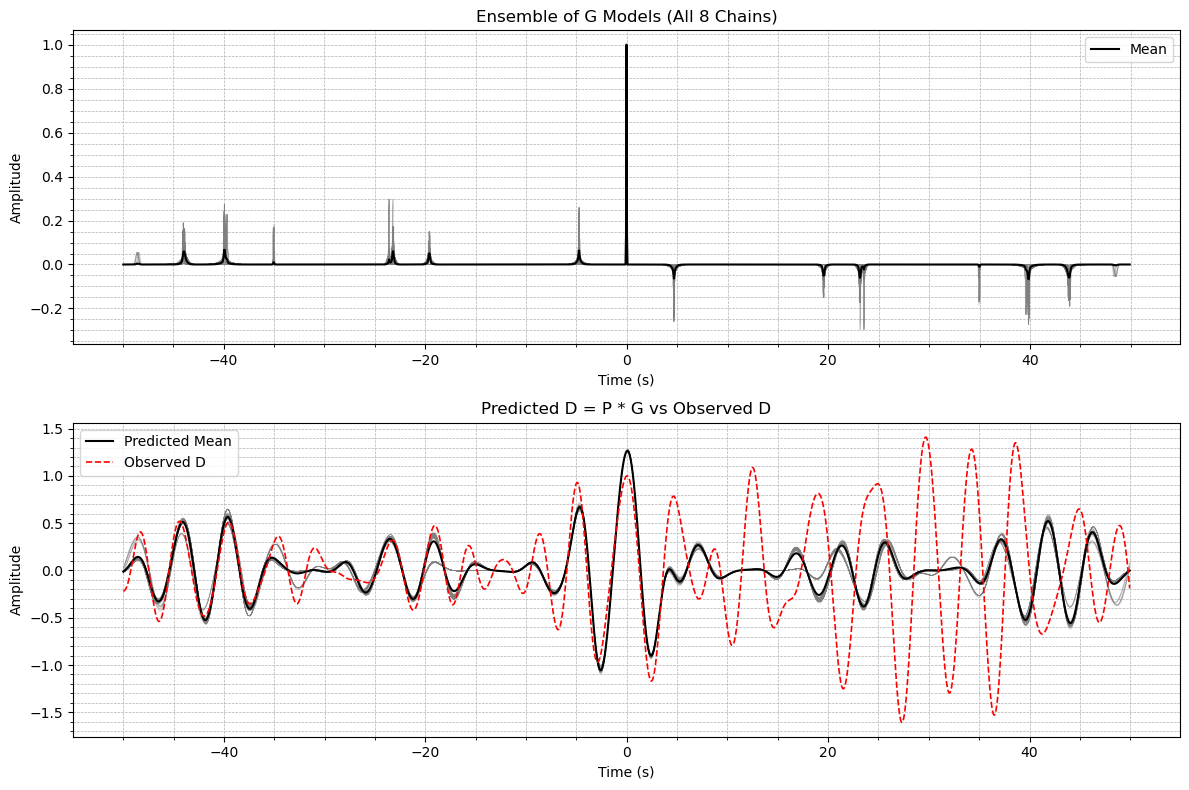

In [5]:
from sharp_ss.visualization import plot_rjmcmc_results

base_dir = "./S0976a_SS/"

plot_rjmcmc_results(base_dir, num_chains=8, ensemble_filename="ensemble.pkl", npz_filename="S0976a_SS.npz")

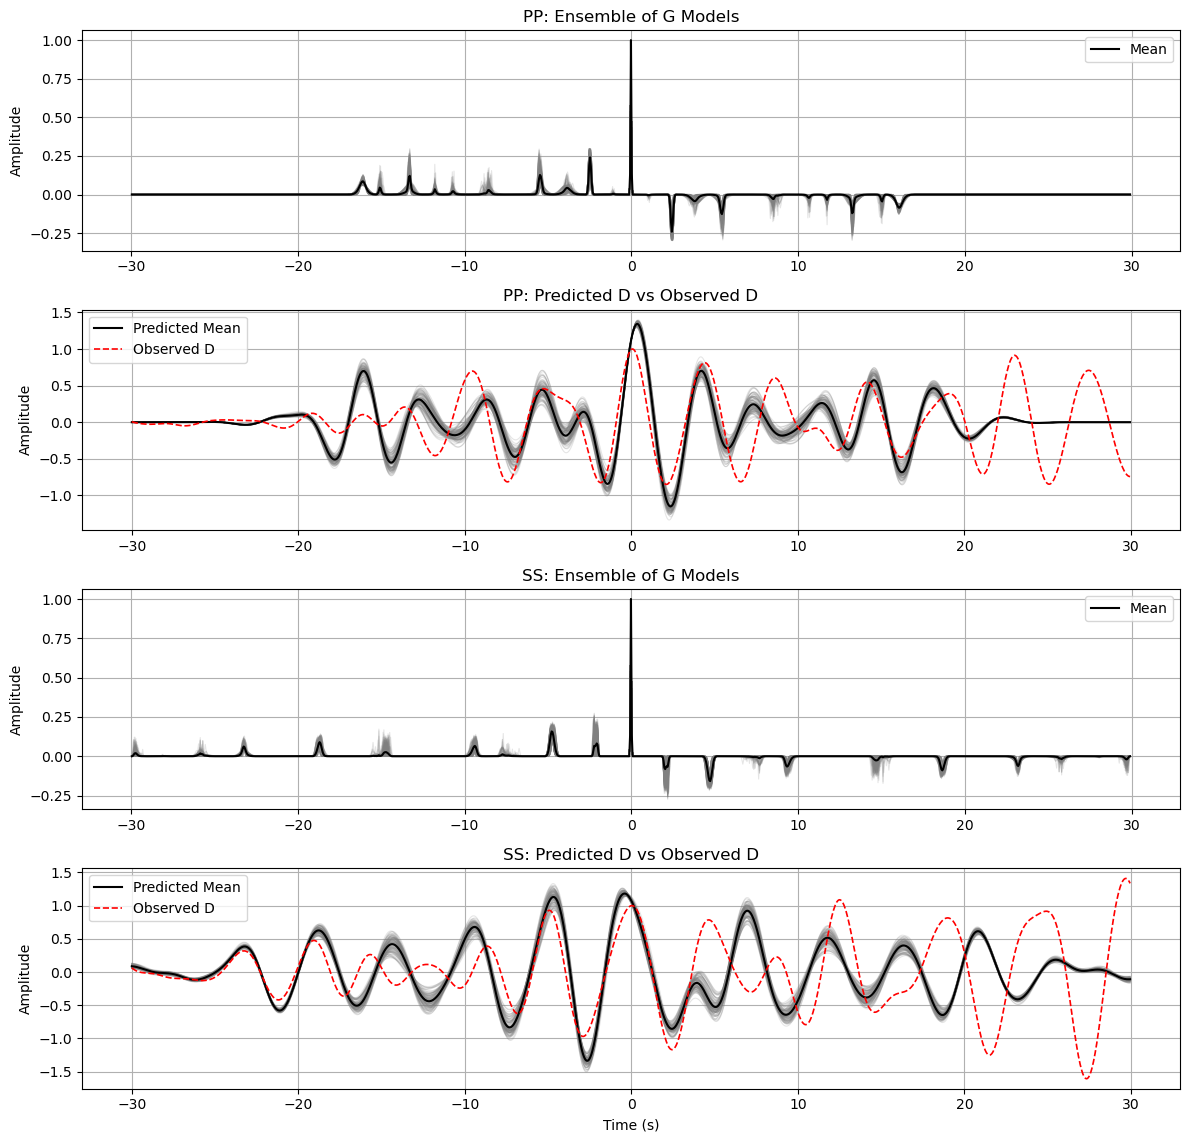

In [2]:
from sharp_ss.visualization import plot_rjmcmc_results_PP_SS_mars

basedir = './S0976a_PP_SS/'
npz_PP = './S0976a_PP/S0976a_PP.npz'
npz_SS = './S0976a_SS/S0976a_SS.npz'

plot_rjmcmc_results_PP_SS_mars(
    basedir=basedir,
    npz_PP=npz_PP,
    npz_SS=npz_SS)

dict_keys(['__header__', '__version__', '__globals__', 'SS_seg_corr_avg', 'S_seg_corr_avg', 'seg_time', 'P_attenuated'])


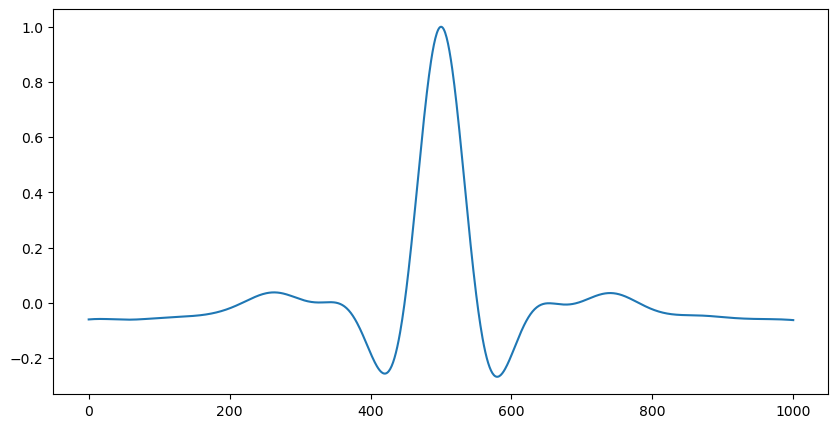

In [32]:
from scipy.io import loadmat

data = loadmat("SS_matchfiltered_NoMelt.mat")

# View available variables
print(data.keys())

plt.figure(figsize=(10,5))
plt.plot(data["S_seg_corr_avg"])

P = data["S_seg_corr_avg"]
D = data["SS_seg_corr_avg"]
Ptime = data["seg_time"]

P, D, Ptime = P.ravel(), D.ravel(), Ptime.ravel()
dt = Ptime[1] - Ptime[0]

prior = Prior(tlen=Ptime[-1], stdP=0.1, dt=dt, widRange=(0.1, 5))

import pickle
# Save prior
with open("./NoMelt/prior.pkl", "wb") as f:
    pickle.dump(prior, f)

# Save
np.savez("./NoMelt/data.npz", P=P, D=D)

In [3]:
from obspy.taup.taup_create import build_taup_model
from obspy.taup import TauPyModel
import os

moddir = "H:\My Drive\Research\MarsData\models_Mars"
# moddir = "/Users/evanzhang/zzq@umd.edu - Google Drive/My Drive/Research/MarsData/models_Mars"
modname = 'InSight_KKS21'

build_taup_model(os.path.join(moddir, modname+'.nd'), output_folder=moddir)
model = TauPyModel(modname+'.npz')

# Define source depth (km) and distance (degrees)
depth = 50.  # source depth in km
distance = 146.3  # source-receiver distance in degrees

# Optional: list of phases to compute
phases = ["PP", "SS"]

# Get arrivals
arrivals = model.get_travel_times(
    source_depth_in_km=depth,
    distance_in_degree=distance,
    phase_list=phases
)

# Print results
for arr in arrivals:
    print(f"{arr.name:<6} time: {arr.time:6.2f} s  ray param: {arr.ray_param:.4f} s/deg")


Building obspy.taup model for 'H:\My Drive\Research\MarsData\models_Mars\InSight_KKS21.nd' ...
filename = H:\My Drive\Research\MarsData\models_Mars\InSight_KKS21.nd
Done reading velocity model.
Radius of model . is 3389.5
Using parameters provided in TauP_config.ini (or defaults if not) to call SlownessModel...
Parameters are:
taup.create.min_delta_p = 0.1 sec / radian
taup.create.max_delta_p = 11.0 sec / radian
taup.create.max_depth_interval = 115.0 kilometers
taup.create.max_range_interval = 0.04363323129985824 degrees
taup.create.max_interp_error = 0.05 seconds
taup.create.allow_inner_core_s = True
Slow model  465 P layers,428 S layers
Done calculating Tau branches.
Done Saving H:\My Drive\Research\MarsData\models_Mars\InSight_KKS21.npz
Method run is done, but not necessarily successful.
PP     time: 1019.16 s  ray param: 248.7675 s/deg
PP     time: 1024.86 s  ray param: 291.1530 s/deg
PP     time: 1025.30 s  ray param: 276.8609 s/deg
SS     time: 1878.67 s  ray param: 466.3153 s/de